In [ ]:
# Allow access to google drive for working with images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import torch
from torch import nn

print("Torch Version: ", torch.__version__)

# Setup device-agnoistc code
device = "cuda" if torch.cuda.is_available else "cpu"
print("Available Device:", device)

# Setting Random Seed for Reproducibility
RANDOM_SEED = 0

# Set seed for torch
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

Torch Version:  2.1.0+cu118
Available Device: cuda


# Enter Path to Project Folder

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/mole_project/"
sys.path.append(PROJECT_DIR)

# File Paths

In [ ]:
from pathlib import Path

# Setup path to data folder
image_path = Path(os.path.join(PROJECT_DIR, "melanoma_cancer_dataset"))

# Setup Train and Testing Paths
train_dir = Path(os.path.join(image_path, "train"))
test_dir = Path(os.path.join(image_path, "test"))

# Visualize the train and test paths
train_dir, test_dir

(PosixPath('/content/drive/MyDrive/mole_project/melanoma_cancer_dataset/train'),
 PosixPath('/content/drive/MyDrive/mole_project/melanoma_cancer_dataset/test'))

# 1) Visualize Example Image

Random image path: /content/drive/MyDrive/mole_project/melanoma_cancer_dataset/train/malignant/melanoma_7478.jpg
Mole Class: malignant
Image Height: 300
Image Width: 300


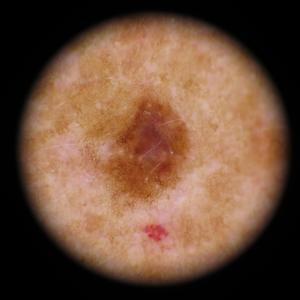

In [ ]:
from src.visualizations import visualize_example_img

# Get an example image from the dataset
img = visualize_example_img(image_path)
img

# 2) Image Transformations

In [ ]:
from src.transformations import train_transform_alexnet, test_transform_alexnet

# import the train and test transformations for the images
train_transform = train_transform_alexnet
test_transform = test_transform_alexnet

print("Train Transformation")
print(train_transform)
print()
print("Test Transformation")
print(test_transform)

Train Transformation
Compose(
    RandomHorizontalFlip(p=0.05)
    RandomApply(
    p=0.05
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
)
    RandomApply(
    p=0.05
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
)
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
)

Test Transformation
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
)


# 3) Defining Training, Validation, and, Testing Data

In [ ]:
from src.dataloader import load_train_val_test

# Load the train, validation and test datasets
train_data, val_data, test_data = load_train_val_test(train_dir, train_transform, test_dir, test_transform, val_perc=0.1)

# Check the length of the training and testing dataset
print(f"Length of Train: {len(train_data)}")
print(f"Length of Validation: {len(val_data)}")
print(f"Length of Test: {len(test_data)}")
print()
print(f"Dimensions of Image: {train_data[0][0].shape}")

Length of Train: 7745
Length of Validation: 860
Length of Test: 2000

Dimensions of Image: torch.Size([3, 224, 224])


# 4) Load data into data loader

In [ ]:
from src.dataloader import load_data_into_dataloader

# Define Batch Size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Load each of the datasets into a data loader
train_dataloader = load_data_into_dataloader(train_data, BATCH_SIZE, NUM_WORKERS)
val_dataloader = load_data_into_dataloader(val_data, BATCH_SIZE, NUM_WORKERS)
test_dataloader = load_data_into_dataloader(test_data, BATCH_SIZE, NUM_WORKERS)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b5db7a03e20>,
 <torch.utils.data.dataloader.DataLoader at 0x7b5db7a01210>)

# 5) Build AlexNet Model

In [ ]:
import torchvision.models as models

# Create an instance of the Alexnet model
model_0 = models.alexnet(pretrained=False).to(device)
model_0.classifier[6] = torch.nn.Linear(4096, 1).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# 6) Train the AlexNet Model

In [ ]:
from src.training_script import train as Train

NUM_EPOCHS = 10
LEARN_RATE = 0.0001

# Setup the loss function and the optimizer
# Binary Cross Entropy Loss
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LEARN_RATE)

# Train the model
model_0_results, model_0_state_dict = Train(model=model_0,
                                            train_dataloader=train_dataloader,
                                            val_dataloader=val_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            epochs=NUM_EPOCHS,
                                            device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 || Train Loss: 0.51859 || Train Accuracy: 0.73851 || Validation Loss: 0.42069 || Validation Accuracy: 0.81611
Epoch: 2 || Train Loss: 0.38515 || Train Accuracy: 0.82464 || Validation Loss: 0.36864 || Validation Accuracy: 0.84976
Epoch: 3 || Train Loss: 0.34355 || Train Accuracy: 0.85498 || Validation Loss: 0.26320 || Validation Accuracy: 0.89784
Epoch: 4 || Train Loss: 0.30051 || Train Accuracy: 0.87229 || Validation Loss: 0.35743 || Validation Accuracy: 0.86298
Epoch: 5 || Train Loss: 0.28372 || Train Accuracy: 0.87887 || Validation Loss: 0.22855 || Validation Accuracy: 0.91587
Epoch: 6 || Train Loss: 0.26622 || Train Accuracy: 0.89075 || Validation Loss: 0.24832 || Validation Accuracy: 0.89663
Epoch: 7 || Train Loss: 0.26602 || Train Accuracy: 0.89127 || Validation Loss: 0.24653 || Validation Accuracy: 0.90144
Epoch: 8 || Train Loss: 0.26748 || Train Accuracy: 0.88908 || Validation Loss: 0.36922 || Validation Accuracy: 0.83534
Epoch: 9 || Train Loss: 0.25912 || Train Accurac

# 7) Save Trained Model Parameters

In [ ]:
# Model Name
MODEL_NAME = f"AlexNet_{NUM_EPOCHS}_epochs"

# The directory to store the model
models_dir = os.path.join(PROJECT_DIR, "models")
file_path = os.path.join(models_dir, MODEL_NAME + ".pth")

# Save the model
torch.save(model_0_state_dict, file_path)